## Consistency Experiments

### Mission:
I want to determine the repeatability of the liquid phenolic resin testing procedure. I will see if the same experimental procedure can produce the same data.
I will look at the change in mass, the position of the exotherm, the height of the exotherm, and the area under the exotherm. If there are differences, I will try
to work out if they are a function of the procedure or an expected reaction (i.e, volatiles evaporating).

### Experimental Procedure: 
10 sample crucibles were weighed in using the lid fold technique. Approximately 20mg of liquid phenolic was added to each, then the lids were punctured and sealed over the crucible. A heating 
rate of 15 degrees celcius per minute was applied to all of them, and the sample mass was measured using the "first measured mass" tickbox in the software.


In [1]:
import pandas as pd
from io import StringIO
from datetime import datetime
import numpy as np
from scipy.stats import pearsonr


def read_dsc_txt(file_path):
    """ Reads the contents of a DSC/TGA txt from filepath, returns cleaned dataframe.

    Args:
        file_path (str): the path of the file
    Returns:
        df (Pandas.DataFrame): the cleaned dataframe of sample run data
        experiment_name (str): the experiment name
        completion_date (Datetime): the time/date of completion
    """

    lines = []

    # open the file with utf-16 encoding
    with open(file_path, 'r', encoding='utf-16') as infile:
        
        # skip the first line with a weird character
        next(infile)

        # remove the index part of each line -- pandas automatically inserts it
        lines = [line for line in infile]

    
    # get the sample info from the string at the bottom
    info = lines[-1].split(',')
    experiment_name = info[0]
    completion_date = datetime.strptime(info[1], " %d.%m.%Y %H:%M:%S\n")

    # remove whitespace
    lines = lines[1:-1]
    
    columns = ["Ts", "t", "HF", "Weight", "Tr"]

    # use .split() to get everything after index
    df = pd.DataFrame([line.split()[1:] for line in lines], columns=columns).astype(float)
   
    return df, experiment_name, completion_date


In [2]:

# everything works, good
df, experiment_name, completion_date = read_dsc_txt('Feb_18_analysis/TEST_WEIGH_IN 20250213_174301_tabular.txt')
print(experiment_name)
print(completion_date)
df.tail()


TEST_WEIGH_IN
2025-02-15 18:12:06


,Ts,t,HF,Weight,Tr
1496,248.220,1496.0,-55.8640,14.5108,250.0
1497,248.223,1497.0,-55.8671,14.5107,250.0
1498,248.223,1498.0,-55.8702,14.5106,250.0
1499,248.230,1499.0,-55.8723,14.5104,250.0
1500,248.225,1500.0,-55.8751,14.5103,250.0


In [3]:

# this looks identical to the display in the Mettler Toledo, so I am fairly confident this is the same.
# next, I load all the files into an list
import os

dsc_folder_path = 'Feb_18_analysis'

df_list = []
name_list = []
date_list = []

# iterate through DSC txt and create dataframe of files
for filename in os.listdir(dsc_folder_path):
    file_path = os.path.join(dsc_folder_path, filename)
    if os.path.isfile(file_path):

        df, name, date = read_dsc_txt(file_path)

        df_list.append(df)
        name_list.append(name)
        date_list.append(date)



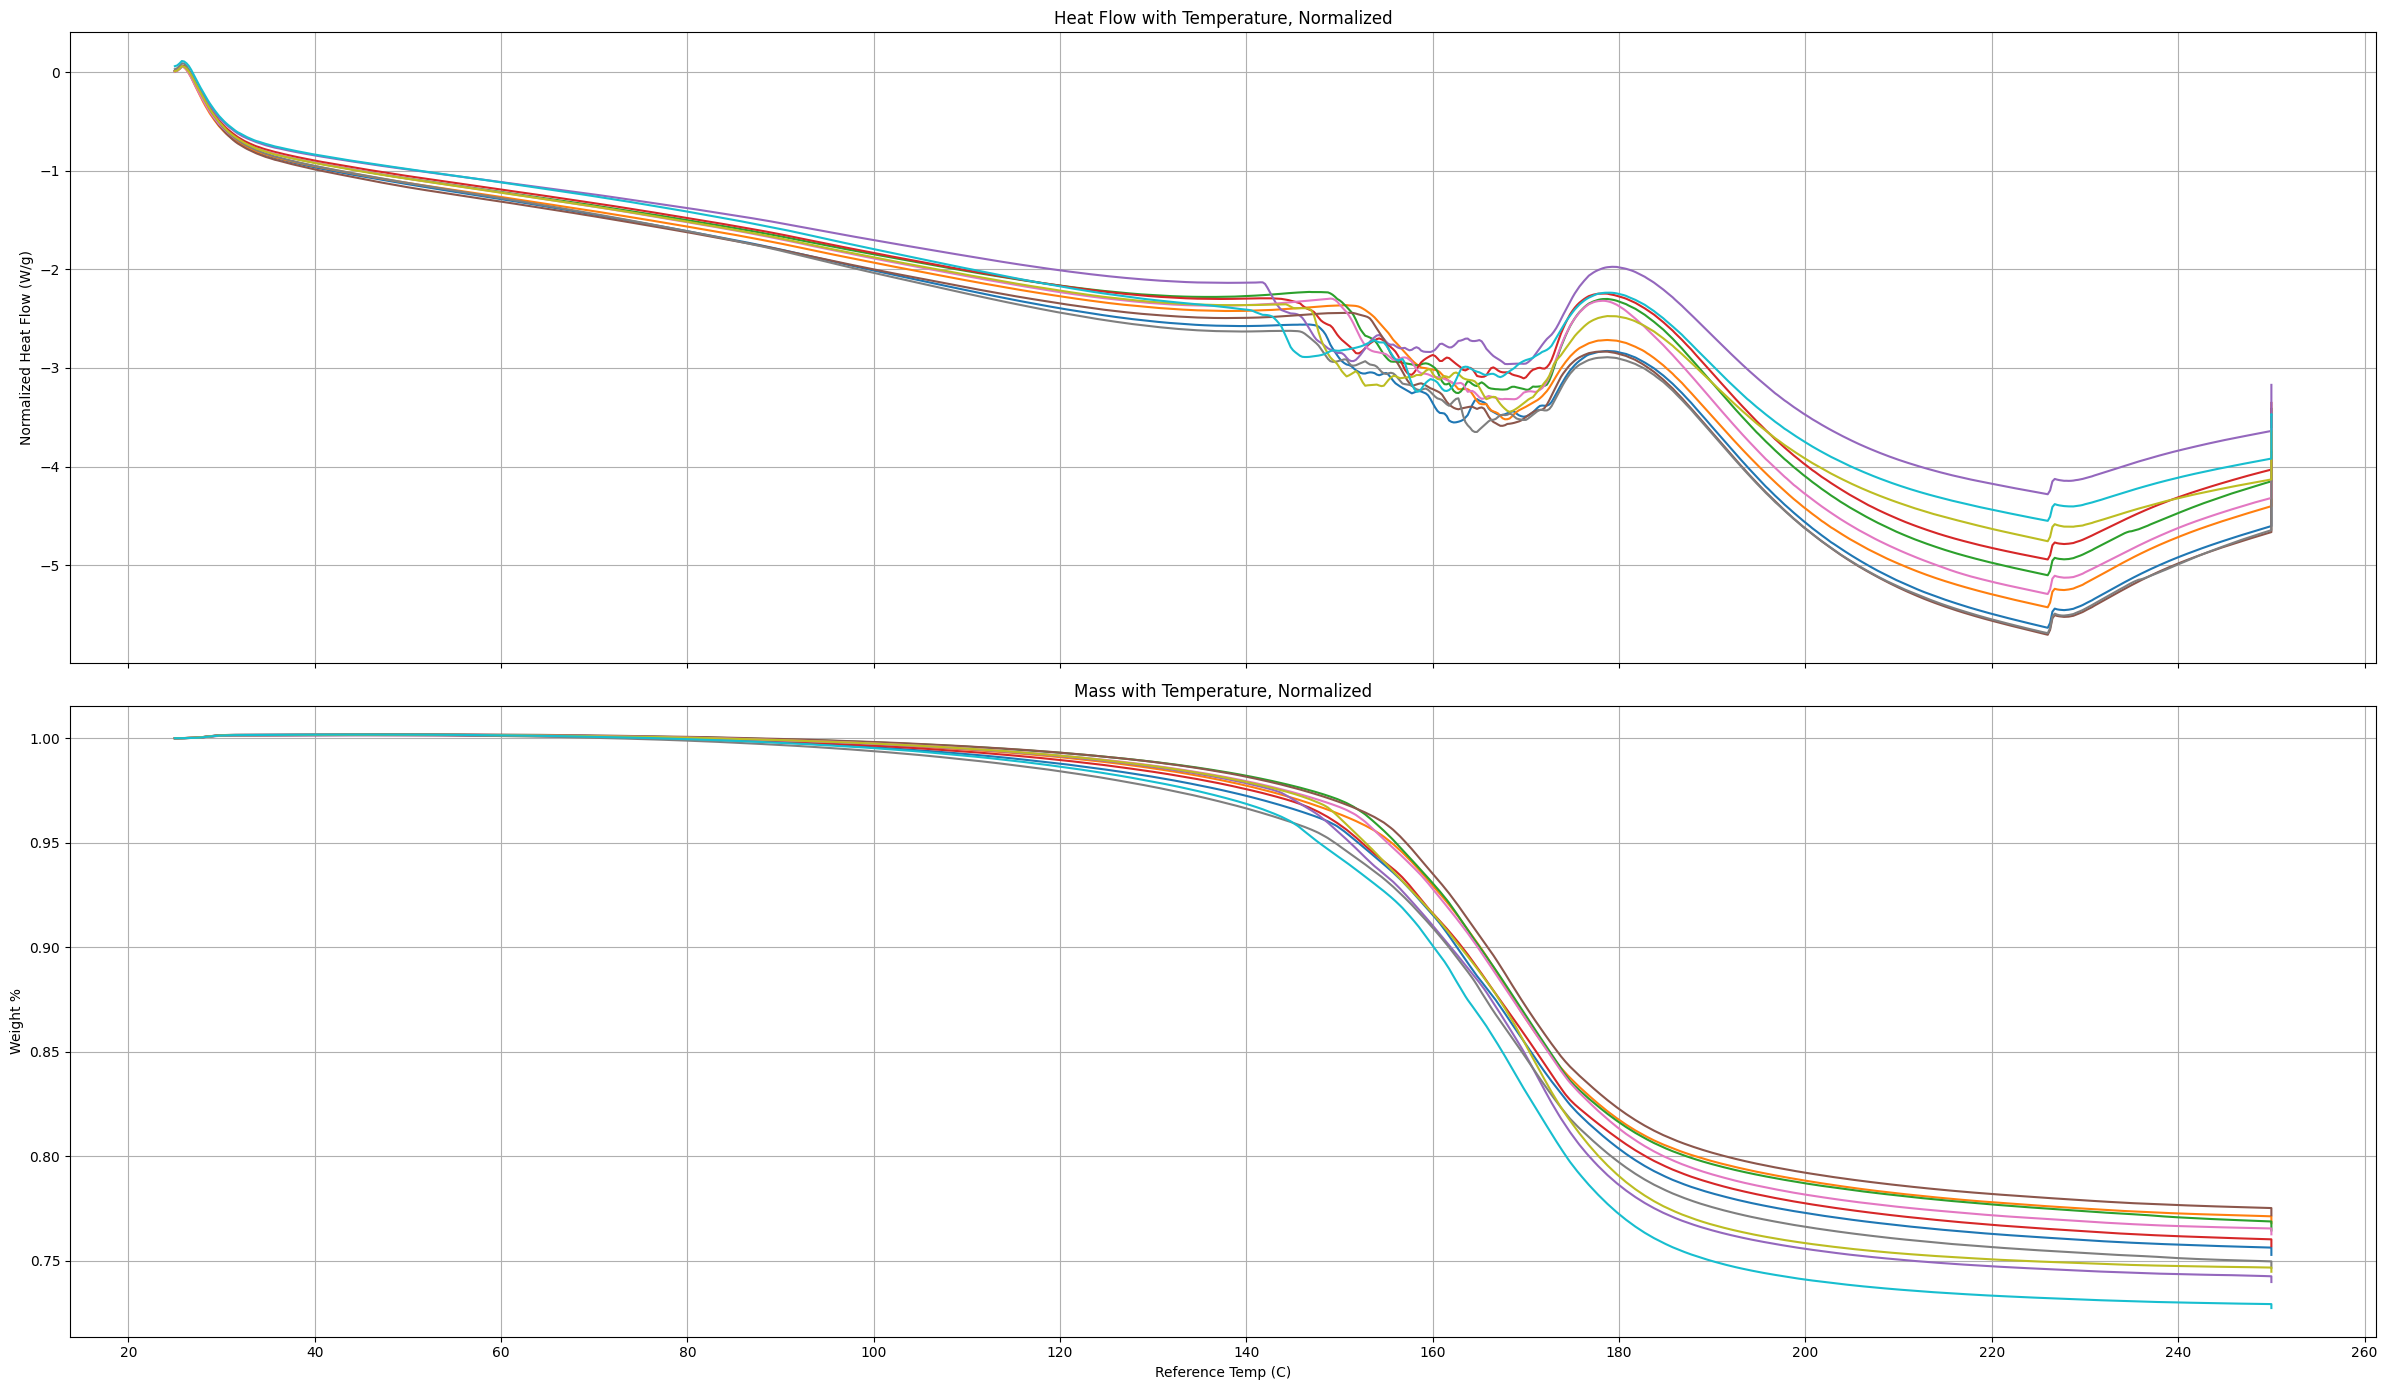

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(24, 14), sharex=True)

# normalized heat flow
for df in df_list:
    df['HF/g'] = df['HF'] / df['Weight']
    axes[0].plot(df['Tr'], df['HF/g'])
    
axes[0].set_ylabel("Normalized Heat Flow (W/g)")
axes[0].set_title("Heat Flow with Temperature, Normalized")
axes[0].grid(True)

# normalized weight percentage
for df in df_list:
    first_measured = df['Weight'].iloc[0]
    df['wt%'] = df['Weight'] / first_measured
    axes[1].plot(df['Tr'], df['wt%'])
    
axes[1].set_xlabel("Reference Temp (C)")
axes[1].set_ylabel("Weight %")
axes[1].set_title("Mass with Temperature, Normalized")
axes[1].grid(True)
axes[1].locator_params(axis='x', nbins=20)


plt.tight_layout()
plt.show()

### What are we seeing here?
This is slightly concerning -- all should have the exact same curve. Why don't they?

It appears that there is some offset that all the curves have. Perhaps clue will arize by plotting the mass. 


In [5]:
def plot_best_fit(x_list, y_list):
    """ Plots a best fit line from a list of x, y values

    Args:
        x_list (list): list of x values
        y_list (list): list of y values
    Returns:
        nothing
    """
    
    # convert to np.array
    x_array = np.array(x_list)
    y_array = np.array(y_list)
    
    # Compute the line of best fit
    slope, intercept = np.polyfit(x_array, y_array, 1)  # 1st-degree polynomial (linear)
    best_fit_line = [slope * xi + intercept for xi in x_list]  # Compute y-values for the line
    
    r_value, _ = pearsonr(x_list, y_list)
    plt.plot(x_list, best_fit_line, label=f"R = {r_value:.3f}", color="red")



In [6]:


# arbitrary temperature
temp_selected = 225

#
masses = []
things = []
things_not_normalized = []
weight_changes = []

for df in df_list:
    masses.append(df.iloc[0]['Weight'])
    things.append(df.loc[df['Tr'] == temp_selected].iloc[0]['HF/g'])
    weight_changes.append((1-df.iloc[1500]['wt%'])*100)



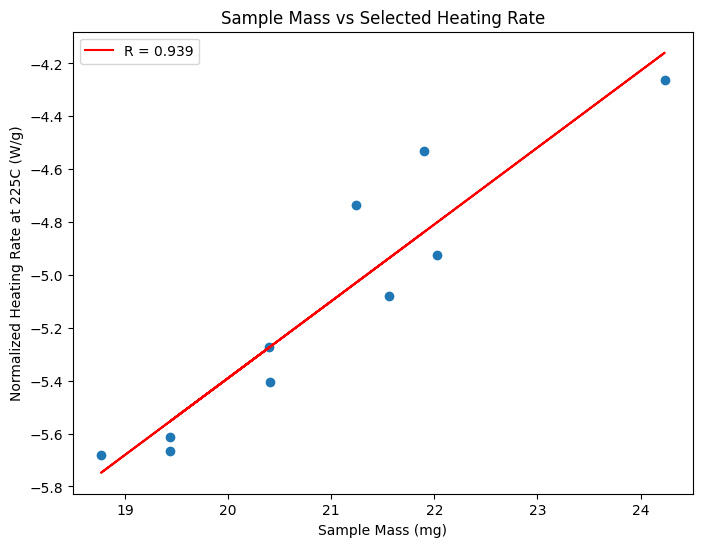

In [7]:


#
plt.figure(figsize=(8,6))

plt.xlabel("Sample Mass (mg)")
plt.ylabel(f"Normalized Heating Rate at {temp_selected}C (W/g)")
plt.title("Sample Mass vs Selected Heating Rate")

plt.scatter(masses, things)
plot_best_fit(masses, things)

plt.legend()
plt.show()

### Results
Strong, positive correlation. This is not good! Since we have akready normalized to the mass, this should be a straight line across (since the samples are the same). 

Lets look at mass change as related to sample mass.

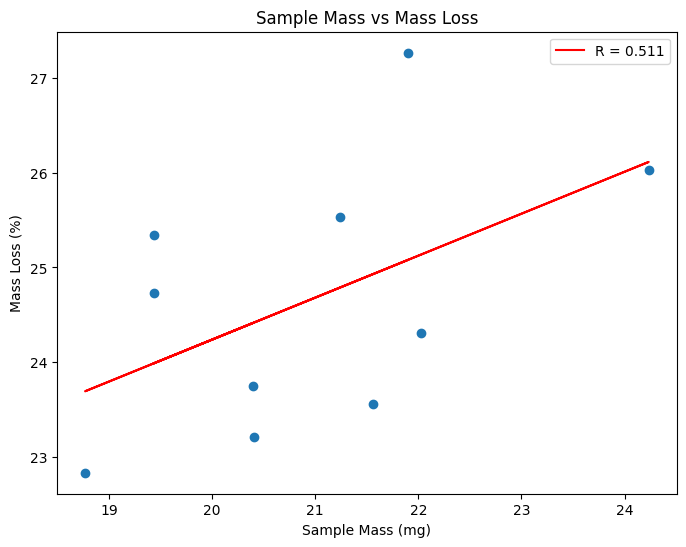

In [8]:

plt.figure(figsize=(8,6))

plt.xlabel("Sample Mass (mg)")
plt.ylabel("Mass Loss (%)")
plt.title("Sample Mass vs Mass Loss")

plt.scatter(masses, weight_changes)
plot_best_fit(masses, weight_changes)

plt.legend()
plt.show()

### Results

Slight positive correlation -- as sample mass increases, more of the sample is lost. Why? Don't know.


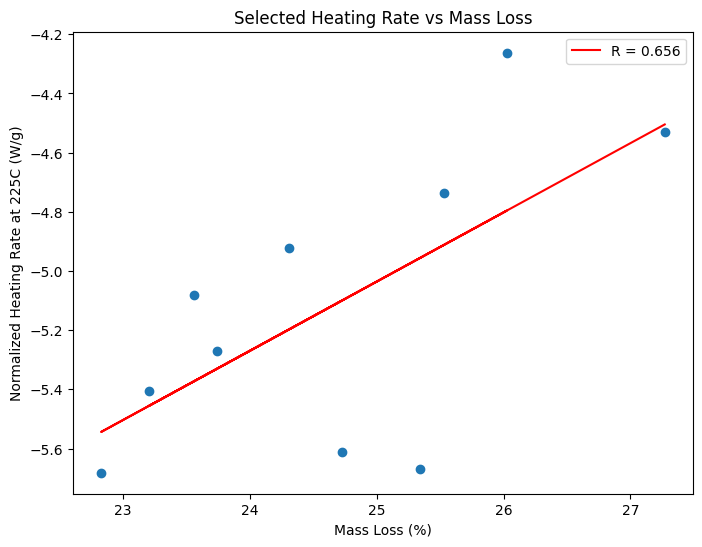

In [9]:

plt.figure(figsize=(8,6))

plt.xlabel("Mass Loss (%)")
plt.ylabel(f"Normalized Heating Rate at {temp_selected}C (W/g)")
plt.title("Selected Heating Rate vs Mass Loss")

plt.scatter(weight_changes, things)

plot_best_fit(weight_changes, things)


plt.legend()
plt.show()



### Results

Fairly strong positive correlation. As more mass is loss, the normalized heating rate is less.

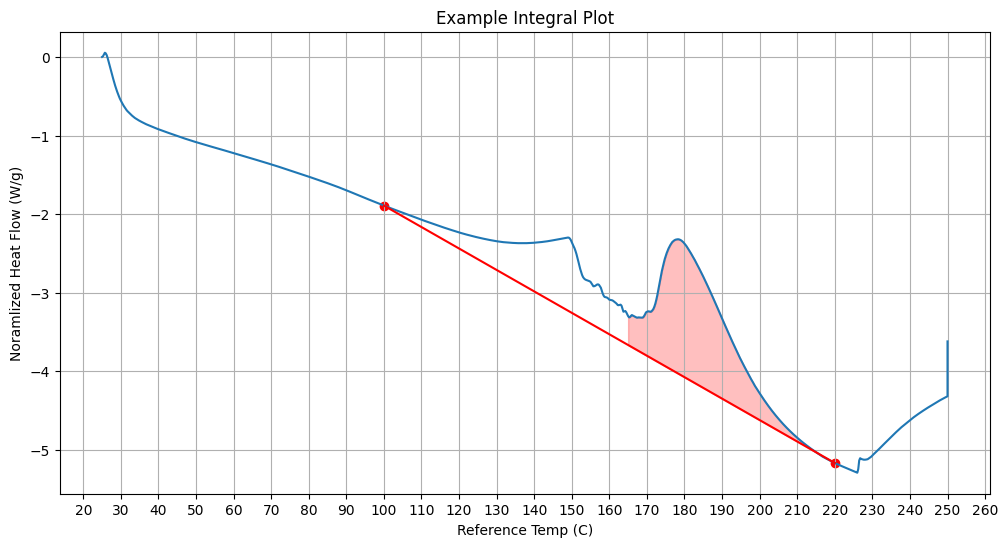

In [10]:
from scipy.integrate import trapezoid

def plot_dsc_int(df):
    """ Only for show -- dont use this later Colin!! """
    
    plt.plot(df['Tr'],df['HF/g'])
    
    # start temp, end temp of the BASELINE
    x1 = 100
    x2 = 220
    y1 = df.loc[df['Tr'] == x1].iloc[0]['HF/g']
    y2 = df.loc[df['Tr'] == x2].iloc[0]['HF/g']
    
    # space out points over the line
    x_values = np.linspace(x1, x2, 100)
    
    # calculate the baseline
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    y_values = m * x_values + b
    
    # plot the baseline and the two points in red
    plt.plot(x_values, y_values, 'r-')
    plt.scatter([x1, x2], [y1, y2], color='red', label='Given points')
    
    # get the range we ant to integrate over
    range_df = df[(df['Tr'] >= 165) & (df['Tr'] <= 220)]
    
    # get points of the baseline
    baseline = m * range_df['Tr'] + b
    
    # integrate, subtracting the baseline
    integral = trapezoid(range_df['HF/g'] - baseline, range_df['Tr'])
    
    # fill the area -- purely visual
    plt.fill_between(range_df['Tr'], range_df['HF/g'], baseline, color='red', alpha=0.25)
    
    # add more lines
    plt.locator_params(axis='x', nbins=30)
    plt.grid(True)

    #print(integral)

plt.figure(figsize=(12,6))

plt.title("Example Integral Plot")
plt.xlabel('Reference Temp (C)')
plt.ylabel('Noramlized Heat Flow (W/g)')


plot_dsc_int(df_list[6])

plt.show()


In [11]:


#print(test_df.iloc[0]['Weight'] - test_df.iloc[1500]['Weight'])

# StarE says @ 200.05, 15.92mg -70.04mW --- W/g = -4.3995
# they say -3.43 W/g  --  ??? what ???

## my prog says at 200C, Hf = -68.2064, wt = 15.9394, Hf/g = -4.2791 -- 


### TODO:

Figure out what StarE is doing because these numbers aint making any damn sense.

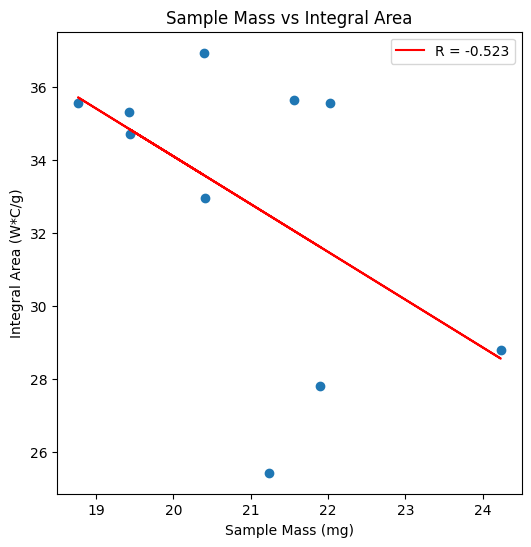

In [12]:


def dsc_integrate(df, baseline_T1, baseline_T2, cutoff_T1, cutoff_T2):
    """ Integrates HF/g above a baseline with respect to reference temperature. 
    Accepts temperature endpoints for the baseline and temperature cutoffs for the integral.

    Args:
        df (Pandas.DataFrame): The dataframe containing columns 'Tr', 'HF/g'
        baseline_T1 (int): start temp of baseline
        baseline_T2 (int): end temp of baseline
        cutoff_T1 (int): start temp of integral cutoff
        cutoff_T2 (int): end temp of integral cutoff
    """
    
    x1 = baseline_T1
    x2 = baseline_T2

    # get the y points of the baseline
    y1 = df.loc[df['Tr'] == x1].iloc[0]['HF/g']
    y2 = df.loc[df['Tr'] == x2].iloc[0]['HF/g']
    
    # space out points over the baseline
    x_values = np.linspace(x1, x2, 100)
    
    # get the equation of the baseline
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1

    # get the range we want to integrate over
    range_df = df[(df['Tr'] >= cutoff_T1) & (df['Tr'] <= cutoff_T2)]
    
    # get points of the baseline (y = mx + b)
    baseline = m * range_df['Tr'] + b
    
    # integrate, subtracting the baseline
    integral = trapezoid((range_df['HF/g'] - baseline), range_df['Tr'])

    return integral

#
integral_list = [dsc_integrate(df,100,220,165,220) for df in df_list]
mass_list = [df['Weight'].iloc[0] for df in df_list]

plt.figure(figsize=(6,6))

plt.title("Sample Mass vs Integral Area")
plt.xlabel('Sample Mass (mg)')
plt.ylabel('Integral Area (W*C/g)')


plot_best_fit(mass_list, integral_list)


plt.scatter(mass_list, integral_list)

plt.legend()
plt.show()

### Results:
Slight negative correlation. As sample mass increases, integral area decreases. This is not great! It means that the sample mass effects the integral, which it really should not if it is normalized.

In [13]:
# output for weekly presentation
sample_names = [f"Sample {x}" for x in range(1,11)]

df = pd.DataFrame({"Sample Name": sample_names, "Sample Mass": mass_list, "Integral": integral_list})

df.round(2)


,Sample Name,Sample Mass,Integral
0,Sample 1,19.43,35.31
1,Sample 2,20.41,32.96
2,Sample 3,21.56,35.64
3,Sample 4,22.02,35.54
4,Sample 5,24.23,28.80
5,Sample 6,18.77,35.57
6,Sample 7,20.39,36.94
7,Sample 8,19.43,34.70
8,Sample 9,21.24,25.42
9,Sample 10,21.90,27.79


In [14]:

# getting the position of the exotherms
def get_exotherm_peak(df, start_temp, end_temp):
    
    range_df = df[(df['Tr'] >= start_temp) & (df['Tr'] <= end_temp)]
    return range_df.loc[range_df['HF/g'].idxmax(), 'Tr']
    

peaks = [get_exotherm_peak(df,160,200) for df in df_list]

df = pd.DataFrame({"Sample Name": sample_names, "Exotherm Peak (C)": peaks})

df.round(2)



,Sample Name,Exotherm Peak (C)
0,Sample 1,178.75
1,Sample 2,178.75
2,Sample 3,178.75
3,Sample 4,178.25
4,Sample 5,179.25
5,Sample 6,178.25
6,Sample 7,178.25
7,Sample 8,178.75
8,Sample 9,178.75
9,Sample 10,178.75
